In [2]:
import numpy as np
import matplotlib.pyplot as plt

BACKWARD EULER WITH SINK TERM

In [46]:
def simulate_dirichlet_sink(u0, b0, D, T, Nt_points, L, Nx_points, a, u_inf = 0):
    """
    Args:
        u0 (1d array): The initial condition. Should be a vector of length Nx_points
        b0 (function of t): The bottom boundary condition U(0,t) = b0(t). Can set to constant by passing e.g. lambda t: 150
        D (float): Thermal diffusivity coefficient of the liquid
        T (float): End time of simulation (seconds)
        Nt_points (int): Number of time points to simulate between 0 and T
        L (float): Height of can (metres)
        Nx_points (int): Number of to discretise x from 0 to L 
        a (float): The heat transfer coefficient for the sink term. Set to 0 for no sink term.
        u_inf (float): The ambient (air) temperature, for the sink term. If no sink term, you can leave this blank        
    Returns:
        U (matrix): A Nx_points by Nt_points matrix, where each column is the simulated heat distribution at a time t.

    """
    dx = L/(Nx_points - 1)
    dt = T/(Nt_points - 1)
    C = D*dt/(dx**2)

    U = np.zeros((Nx_points,Nt_points)) # this is where we'll put results
    U[:,0] = u0 # initial condition

    # This defines the backward Euler timestep AU_{t+1} = U_t. Definition of A is given as below in lectures for dirichlet conditions
    A = np.zeros((Nx_points, Nx_points))
    for i in range(1, Nx_points-1):
        A[i,i-1] = -C
        A[i,i+1] = -C
        A[i,i] = 1 + 2*C    
    # implement the (constant-in-time) Dirichlet conditions (i.e. the end points never change temp, U(0, t+dt) = U(0, t), same at x=1)
    A[0,0] = 1
    A[Nx_points-1,Nx_points-1] = 1

    # Run simulation
    for n in range(1, Nt_points):
        # update u by solving the matrix system AU_{t+1} = U_t
        u_old = U[:,n-1]
        u_new = np.linalg.solve(A,u_old) 
        u_new[1:Nx_points-1] -= a*(u_old[1:Nx_points-1] - u_inf) # This is the sink term - it doesn't affect the endpoints

        u_new[0] = b0(n * T/Nt_points) # enforce bottom boundary condition
        
        U[:,n] = u_new # store heat distribution in the results matrix 

    return U

In [39]:
def create_analytic_toy_fn(b0, bL, L, D, n_sum_terms = 200):
    def U_analyt(x, t):
        """x can be a 1-d array"""
        if t == 0: # initial condition
            sol = bL * np.ones(len(x))
            sol[0] = b0
        else:
            u_d = b0 - bL

            sol = b0 - u_d*(x / L)
            for n in range(1,n_sum_terms):
                sol -= 2*u_d/(n*np.pi) * np.sin(n*np.pi*x/L) * np.exp(-(n*np.pi/L)**2 * D * t)

        return sol
    
    return U_analyt

In [41]:
# User defined parameters

b0 = 150 # u(0,t)= b0 (boundary cond)
bL = 20 # u(L,t)= bL (boundary cond)
D = 0.01 # thermal diffusivity coefficient - in the liquid
a = 0 # heat transfer coefficient of liquid through container to air - for sink term along sides of can
T = 3 # final time 
L = 2 # Length (i.e. height) of the can
Nt_points = 2000    # number of timesteps
Nx_points = 100   # number of spaces in x

u_inf = bL # air temperature - for this problem we say that the temperature at end of rod is fixed at air temp

# Set initial condition
u0 = np.zeros(Nx_points)
u0[0] = b0
u0[1:] = bL*np.ones(Nx_points-1)


In [54]:
# Then we run the simulation
U = simulate_dirichlet_sink(u0, lambda t: b0, D, T, Nt_points, L, Nx_points, 0)

# NOTE: Might need to run this simulation without sink term to see if full can gets up to 80C like we need and note down time it reaches temp 
#   Will run with longer time horizon, ie set Nt_points higher and try this!

Compare numeric to analytic solution

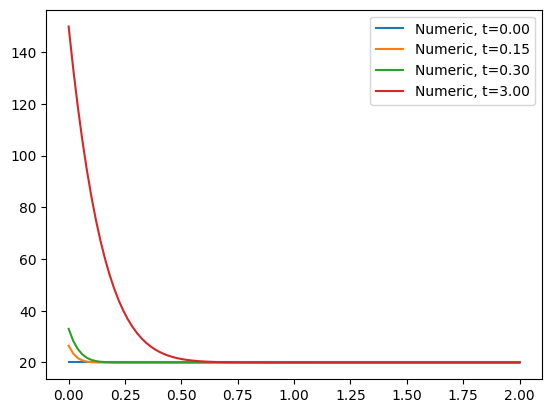

In [55]:
U_analyt = create_analytic_toy_fn(b0, bL, L, D)
x = np.linspace(0,L,Nx_points)

for t in (0, Nt_points//20, Nt_points//10, Nt_points - 1):
    plt.plot(x, U[:, t], "-", label = f"Numeric, t={T * t/(Nt_points - 1):.2f}")
    plt.plot(x, U_analyt(x, t * T/(Nt_points)), ".", label = f"Analytical, t={T * t/(Nt_points - 1):.2f}")
    

plt.legend()
plt.show()

Newton cooling at top of can

In [ ]:
##  Newton cooling at top of can
##  Jack's Code
##  x and t parameters and BC conditions same as above
##  For re-used parameters, ie A_nct and U, added "_nct" for newton cooling at top

# Heat transfer coefficient and ambient temperature
a = 0.05
h = 0.1  # heat transfer coefficient for Newton cooling (top boundary)


# Initialize matrices for storing solutions
U_nct = np.zeros((Nx_points, Nt_points))

# Define the tridiagonal matrix A_nct for the backward Euler scheme
A_nct = np.zeros((Nx_points, Nx_points))
for i in range(1, Nx_points - 1):
    A_nct[i, i - 1] = -C
    A_nct[i, i + 1] = -C
    A_nct[i, i] = 1 + 2 * C

# Implement boundary conditions
A_nct[0, 0] = 1  # Dirichlet condition at the bottom
A_nct[Nx_points - 1, Nx_points - 1] = 1 + h * dt / dx  # Newton cooling at the top


# NOTE: Sets bottom of can from 150C to 950C
#       top of can dropping lower than 20C because of cooling
#       set b0 to 150 to see what happens here when Newton cooling added
#       currently can only see what happens at 950C in data; all in plot
#       What we can investigate: what happens when bottom held at 150C and cooling term varies

# Set different bottom boundary conditions for investigation
b0_values = np.arange(150, 1001, 100)  # Different constant boundary values at x = 0 (bottom of the can)

for b0 in b0_values:
    # Set initial conditions
    u_old = 20 * np.ones(Nx_points)  # Initial temperature at t = 0
    u_old[0] = b0  # Set bottom boundary condition
    U_nct[:, 0] = u_old[:]

    # Time-stepping loop for the backward Euler method
    for n in range(1, Nt_points):
        # Set the boundary values in vector b
        b = u_old.copy()
        b[0] = b0  # Constant bottom boundary condition
        b[-1] = u_old[-1] + h * dt * (u_inf - u_old[-1]) / dx  # Newton cooling boundary condition at the top


# NOTE: Don't think we were meant to do this as it's unstable!!! Workshop 2 notes 
    
        # U_nctpdate u by solving the matrix system A_nct * u_new = b
        u_new = np.linalg.solve(A_nct, b)
        u_new[1:Nx_points - 1] -= a * (u_old[1:Nx_points - 1] - u_inf)  # A_nctpply heat transfer to the surrounding air

        # U_nctpdate u_old before the next step
        u_old = u_new
        U_nct[:, n] = u_new

    # Plot the temperature distribution at the final time step
    t_final = Nt_points - 1
    plt.plot(x, U_nct[:, t_final], label=f"Temperature at t = {T}, b0 = {b0}")

plt.xlabel("Position along the can (x)")
plt.ylabel("Temperature (u)")
plt.title("Temperature distribution along the can at final time for different bottom boundary conditions")
plt.legend()
plt.grid(True)
plt.show()

Newton cooling at bottom of can

In [ ]:
##  Newton cooling at bottom of can
##  Jamie's Code
##  adapted code from Jack
##  x and t parameters and BC conditions same as above
##  h: Heat transfer coefficient for Newton cooling at the bottom boundary. NB: Material dependent! 
##      SHOULD BE SAME THROUGHOUT CODE UNLESS WE CHANGE CAN MATERIALS
##  For re-used parameters, ie A and U, added "_ncb" for newton cooling at top
##  RESOURCE: https://uk.mathworks.com/help/simscape/ug/heat-conduction-through-iron-rod.html

# Initialize matrices for storing solutions
U_ncb = np.zeros((Nx_points, Nt_points))

# Define the tridiagonal matrix A_ncb for the backward Euler scheme
A_ncb = np.zeros((Nx_points, Nx_points))
for i in range(1, Nx_points - 1):
    A_ncb[i, i - 1] = -C
    A_ncb[i, i + 1] = -C
    A_ncb[i, i] = 1 + 2 * C

# Implement boundary conditions
A_ncb[0, 0] = 1 + h * dt / dx  # Newton cooling at bottom
A_ncb[Nx_points - 1, Nx_points - 1] = 1  # Dirichlet condition at top


# NOTE: Sets bottom of can from 150C to 950C
#       top of can dropping lower than 20C because of cooling
#       set b0 to 150 to see what happens here when Newton cooling added
#       currently can only see what happens at 950C
#       What we can investigate: what happens when bottom held at 150C and cooling term varies

# Set different bottom boundary conditions for investigation
b0_values = np.arange(150, 1001, 100)  # Different constant boundary values at x = 0 (bottom of the can)

for b0 in b0_values:
    # Set initial conditions
    u_old = 20 * np.ones(Nx_points)  # Initial temperature at t = 0
    u_old[0] = b0  # Set bottom boundary condition
    U_ncb[:, 0] = u_old[:]

    # Time-stepping loop for the backward Euler method
    for n in range(1, Nt_points):
        # Set the boundary values in vector b
        b = u_old.copy()
        #b[0] = b0  # Constant bottom boundary condition
        b[0] = u_old[0] + h * dt * (u_inf - u_old[0]) / dx  # Newton cooling boundary condition at the bottom

        # U_ncbpdate u by solving the matrix system A_ncb * u_new = b
        u_new = np.linalg.solve(A_ncb, b)
        u_new[1:Nx_points - 1] -= a * (u_old[1:Nx_points - 1] - u_inf)  # A_ncbpply heat transfer to the surrounding air

        # U_ncbpdate u_old before the next step
        u_old = u_new
        U_ncb[:, n] = u_new

    # Plot the temperature distribution at the final time step
    t_final = Nt_points - 1
    plt.plot(x, U_ncb[:, t_final], label=f"Temperature at t = {T}, b0 = {b0}")

plt.xlabel("Position along the can (x)")
plt.ylabel("Temperature (u)")
plt.title("Temperature distribution along the can at final time for different bottom boundary conditions")
plt.legend()
plt.grid(True)
plt.show()
